# Применение моделей глубинного обучения

## Импорты, загрузка данных

In [1]:
# Импорты
import pandas as pd
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss
import gdown
import numpy as np
import torch
import torch.nn as nn
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW

import ml_utils as mu

/home/ubuntu/project_hubs/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Загрузка данных

In [2]:
# Сэмпл датасета (10%) для подбора оптимальной модели
sample_10_id = '17IVd8t37FZ-WULTMCnsUv8vbd6PuzeKx'
gdown.download(f"https://drive.google.com/uc?id={sample_10_id}", quiet=True)

# 50% датасета (которые поместились в 32гб оперативки)
df_50_id = '12mIlvk7Fb7yfdvoml7dmE-8TuGLh4c-V'
gdown.download(f"https://drive.google.com/uc?id={df_50_id}", quiet=True)

# Если понадобится - полный датасет (400к статей)
# df_100_id = '1YvQ2kxQqq1JJBfzTqygftj_RMOnV0ZTd'
# gdown.download(f"https://drive.google.com/uc?id={df_100_id}", quiet=False)

'df_final_50.parquet'

In [2]:
df = pd.read_parquet("df_final_50.parquet")

In [3]:
df.head(2)

,author,publication_date,hubs,comments,views,url,reading_time,individ/company,bookmarks_cnt,text_length,rating_new,text_pos_tags,tags_tokens,title_tokens,text_tokens
0,LivingDead,2011-09-13 14:45:04+00:00,Разработка игр,16,34000,https://habr.com/ru/articles/128368/,2.0,individual,78.0,2677,21.0,"[PRON, ADJ, NOUN, NOUN, PRON, VERB, AUX, VERB,...","[minecraft, noise, perlin, d, landscape]","[генерация, ландшафт, minecraft]","[добрый, время, суток, поделиться, личный, опы..."
1,AlfaTeam,2022-09-07 12:19:42+00:00,"Блог компании Альфа-Банк, JavaScript, Программ...",13,19000,https://habr.com/ru/companies/alfa/articles/68...,8.0,company,44.0,12132,18.0,"[PRON, VERB, ADP, ADJ, NOUN, PROPN, PRON, VERB...","[react, react, router, react, reactrouter, мар...","[переходить, reactrouter, v, подводный, камень...","[перейти, шестой, версия, reactrouter, помочь,..."


In [4]:
# Выделение рейтинга статьи
df['rating_level'] = mu.categorize_ratings(df)

# Предобработка датасета: фильтрация, объединение текстовых токенов,
# кодировка меток(хабов) и преобразование рейтингов
(df_prepr, y_multi_reduced, selector,
index_to_label, mlb,
y_rating, inverse_rating_mapping, indices) = mu.df_preprocess(df)

### Предобработка данных

In [5]:
class MultiLabelTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = label
        return item

In [6]:
# Оставим только необходимые столбцы
X = df_prepr[['text_combined']].copy()
text_col = 'text_combined'

# Выделям матрицы признаков признаков для хабов и рейтинга
X_hubs = X.iloc[indices].copy()
X_rating = X.copy()

# Разделение на обучающую и тестовую выборки для предсказания хабов (тем) статей
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hubs, y_multi_reduced, test_size=0.25)

# Разделение на обучающую и тестовую выборки для предсказания рейтинга статьи
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_rating, y_rating, test_size=0.25)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

train_dataset_h = MultiLabelTextDataset(X_train_h["text_combined"].to_list(), y_train_h, tokenizer)
val_dataset_h = MultiLabelTextDataset(X_test_h["text_combined"].to_list(), y_test_h, tokenizer)
train_loader_h = DataLoader(train_dataset_h, batch_size=8, shuffle=True)
val_loader_h = DataLoader(val_dataset_h, batch_size=8)

### Архитектура нейросети, обучение

In [8]:
class BertForMultiLabel(torch.nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled = outputs.pooler_output
        dropped = self.dropout(pooled)
        logits = self.classifier(dropped)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Функция для оценки модели на тестовой выборке
# Возвращает loss, f1-score по эпохам
from tqdm import tqdm
def test(model, loader, criterion, model_type):
    loss_log = []
    all_preds = []
    all_targets = []
    model.eval()

    for batch in tqdm(loader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        target = batch['labels'].to(device)

        # forward
        with torch.no_grad():
            y_pred = model(**inputs)
        loss = criterion(y_pred, target)
        loss_log.append(loss.item())

        # predict
        if isinstance(criterion, nn.BCEWithLogitsLoss):
            pred_probs = torch.sigmoid(y_pred)
            pred_classes = (pred_probs > 0.5).float().cpu().numpy()
        elif isinstance(criterion, nn.CrossEntropyLoss):
            pred_classes = y_pred.argmax(dim=-1).cpu().numpy()

        target_np = target.cpu().numpy()
        all_preds.append(pred_classes)
        all_targets.append(target_np)



    # Объединяем предсказания и метки
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Считаем метрики
    f1 = f1_score(all_targets, all_preds, average='micro')
    precision = precision_score(all_targets, all_preds, average='micro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='micro', zero_division=0)
    hamming = hamming_loss(all_targets, all_preds)

    return np.mean(loss_log), f1, precision, recall, hamming

# Функция обучения модели в течение 1 эпохи
# Возвращает loss и f1-score по батчам
def train_epoch(model, optimizer, train_loader, criterion, model_type):
    loss_log = []
    f1_log = []
    model.train()

    for batch in tqdm(train_loader):
        # zero gradients
        optimizer.zero_grad()

        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        target = batch['labels'].to(device)
        y_pred = model(**inputs)

        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()

        # Метрики
        if isinstance(criterion, nn.BCEWithLogitsLoss):
            pred_probs = torch.sigmoid(y_pred)
            pred_classes = (pred_probs > 0.5).float().cpu().numpy()
        elif isinstance(criterion, nn.CrossEntropyLoss):
            pred_classes = y_pred.argmax(dim=-1).cpu().numpy()

        target_np = target.cpu().numpy()
        f1 = f1_score(target_np, pred_classes, average='micro')
        loss_log.append(loss.item())
        f1_log.append(f1)


    return loss_log, f1_log

In [10]:
# Общая функция для обучения/теста модели
def train(model, optimizer, n_epochs, train_loader, test_loader,
          train_epoch, test_func, task_type, criterion, model_type):
    # логи по батчам
    train_loss_all, train_f1_all = [], []
    # логи по эпохам
    test_loss_log, test_f1_log = [], []
    test_prec_log, test_rec_log, test_ham_log = [], [], []

    steps_per_epoch = len(train_loader)

    for epoch in range(n_epochs):
        # train_epoch теперь возвращает списки по батчам
        batch_losses, batch_f1s = train_epoch(model, optimizer, train_loader, criterion, model_type)
        train_loss_all.extend(batch_losses)
        train_f1_all.extend(batch_f1s)

        # валидируем раз в эпоху
        test_loss, test_f1, test_prec, test_rec, test_ham = test_func(model, test_loader, criterion, model_type)
        test_loss_log.append(test_loss)
        test_f1_log.append(test_f1)
        test_prec_log.append(test_prec)
        test_rec_log.append(test_rec)
        test_ham_log.append(test_ham)

        # выводим раз в 5 эпох
        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(batch_losses):.4f}, train f1: {np.mean(batch_f1s):.4f}")

        if task_type == 'hubs':
            print(f" test loss: {np.mean(test_loss):.4f}, test f1: {test_f1:.4f}, test precision: {test_prec:.4f}, test recall: {test_rec:.4f}, test hamming: {test_ham:.4f}\n")
        elif task_type == 'rating':
            print(f" test loss: {test_loss:.4f}, test f1: {test_f1:.4f}, test hamming: {test_ham:.4f}\n")

    return (train_loss_all, train_f1_all,
            test_loss_log, test_f1_log,
            test_prec_log, test_rec_log, test_ham_log,
            steps_per_epoch)

In [19]:
# Обучаем модель хабов

# Задаём все переменные для предсказания хабов
num_labels = len(y_train_h[0])
model_h = BertForMultiLabel('bert-base-multilingual-cased', num_labels).to(device)
optimizer_h = AdamW(model_h.parameters(), lr=2e-5)

(train_loss_log, train_f1_log, test_loss_log, test_f1_log,
 test_prec_log, test_rec_log, test_ham_log, steps_per_epoch) = train(
    model_h, optimizer_h, 5, train_loader_h,
    val_loader_h, train_epoch, test,
    task_type='hubs', criterion=nn.BCEWithLogitsLoss(), model_type='fc')

100%|██████████| 3568/3568 [14:47<00:00,  4.02it/s]


Epoch 0
 train loss: 0.0830, train f1: 0.2917
 test loss: 0.0623, test f1: 0.5116, test precision: 0.7160, test recall: 0.3980, test hamming: 0.0203



100%|██████████| 3568/3568 [15:12<00:00,  3.91it/s]


Epoch 1
 train loss: 0.0583, train f1: 0.5317
 test loss: 0.0567, test f1: 0.5662, test precision: 0.7155, test recall: 0.4684, test hamming: 0.0192



100%|██████████| 3568/3568 [14:54<00:00,  3.99it/s]


Epoch 2
 train loss: 0.0514, train f1: 0.5998
 test loss: 0.0543, test f1: 0.5858, test precision: 0.7278, test recall: 0.4902, test hamming: 0.0185



100%|██████████| 3568/3568 [14:41<00:00,  4.05it/s]


Epoch 3
 train loss: 0.0456, train f1: 0.6547
 test loss: 0.0541, test f1: 0.6114, test precision: 0.6988, test recall: 0.5435, test hamming: 0.0184



100%|██████████| 3568/3568 [15:24<00:00,  3.86it/s]


Epoch 4
 train loss: 0.0405, train f1: 0.7013
 test loss: 0.0547, test f1: 0.6190, test precision: 0.6875, test recall: 0.5628, test hamming: 0.0185



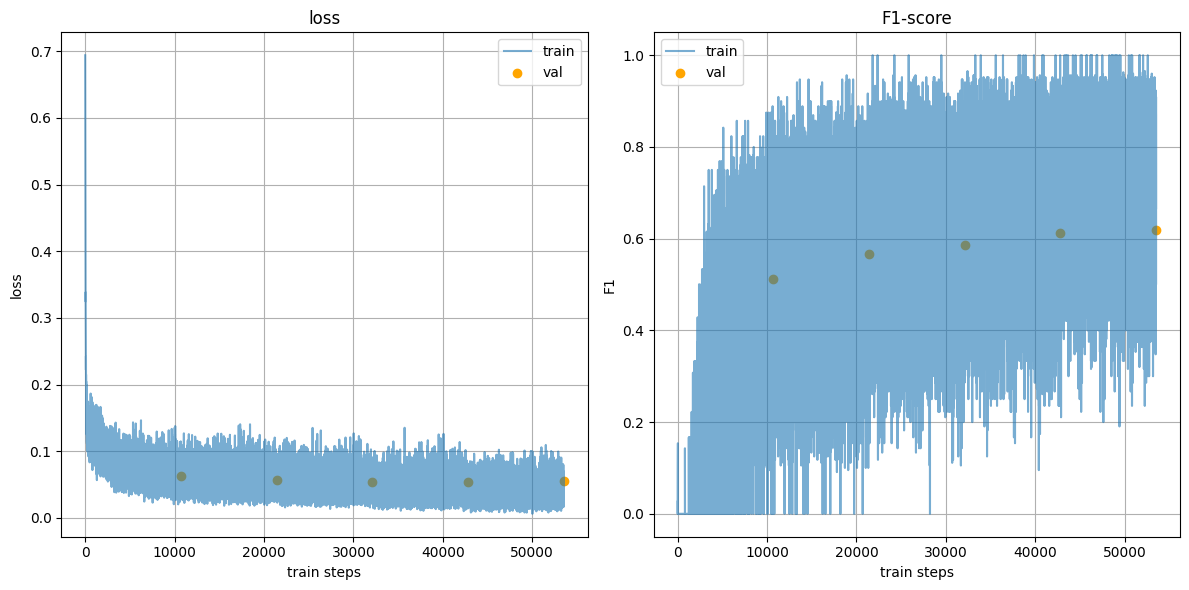

In [20]:
# Визуализируем для хабов
mu.plot_history(train_loss_log, train_f1_log, test_loss_log, test_f1_log,
             steps_per_epoch=steps_per_epoch,  figsize=(12,6))

`Выводы для модели хабов`
* На графике потерь видно, что на тренировочной и тестовой выборках loss снижается первые 3 эпохи и стабилизируется на уровне 0.05-0.06 (довольно низкий loss), то есть модель успешно сходится и не переобучается (что видно также по близким метрикам train f1 - 0.5998 и test f1 - 0.5858). После 3 эпохи можем наблюдать переобучение модели - валидационный лосс не меняется, precision увеличивается, но recall и f1-score растет.
* Итоговые значения на тестовой выборке f1-score (micro) 0.619, что говорит о хорошем качестве предсказаний, precision и recall сближаются 0.6875 и 0.5628 соответственно - перекос стал меньше в отличии от экспериментов с ML моделями, hamming loss довольно низкий (0.018), то есть доля ошибочно предсказанных меток мала

# Предсказание рейтинга

In [11]:
class RatingTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = label
        return item

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

train_dataset_r = RatingTextDataset(X_train_r["text_combined"].to_list(), y_train_r.to_list(), tokenizer)
val_dataset_r = RatingTextDataset(X_test_r["text_combined"].to_list(), y_test_r.to_list(), tokenizer)
train_loader_r = DataLoader(train_dataset_r, batch_size=8, shuffle=True)
val_loader_r = DataLoader(val_dataset_r, batch_size=8)

In [13]:
n_classes_r = len(set(y_train_r))
model_r = BertForMultiLabel('bert-base-multilingual-cased', n_classes_r).to(device)
optimizer_r = AdamW(model_r.parameters(), lr=2e-5)

# Обучаем модель для рейтинга
(train_loss_log, train_f1_log, test_loss_log,
test_f1_log, test_prec_log, test_rec_log,
test_ham_log, steps_per_epoch) = train(
    model_r, optimizer_r, 5, train_loader_r,
    val_loader_r, train_epoch, test,
    task_type='rating', criterion=nn.CrossEntropyLoss(), model_type='fc')

100%|██████████| 4372/4372 [17:36<00:00,  4.14it/s]


Epoch 0
 train loss: 1.1960, train f1: 0.4371
 test loss: 1.1654, test f1: 0.4524, test hamming: 0.5476



100%|██████████| 4372/4372 [18:13<00:00,  4.00it/s]


Epoch 1
 train loss: 1.2126, train f1: 0.4376
 test loss: 1.3613, test f1: 0.2954, test hamming: 0.7046



100%|██████████| 4372/4372 [18:06<00:00,  4.02it/s]


Epoch 2
 train loss: 1.2216, train f1: 0.4367
 test loss: 1.3157, test f1: 0.2954, test hamming: 0.7046



100%|██████████| 4372/4372 [18:36<00:00,  3.92it/s]


Epoch 3
 train loss: 1.2235, train f1: 0.4352
 test loss: 1.2294, test f1: 0.4351, test hamming: 0.5649



100%|██████████| 4372/4372 [18:13<00:00,  4.00it/s]


Epoch 4
 train loss: 1.2267, train f1: 0.4354
 test loss: 1.2263, test f1: 0.4351, test hamming: 0.5649



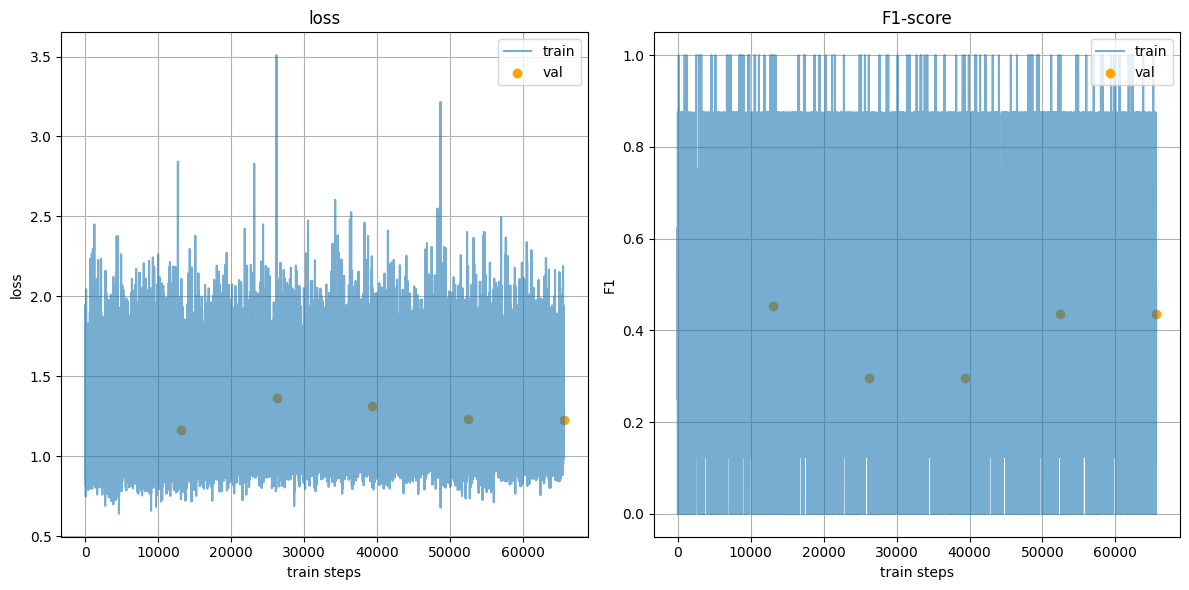

In [14]:
# Визуализируем для рейтинга
mu.plot_history(train_loss_log, train_f1_log, test_loss_log, test_f1_log,
             steps_per_epoch=steps_per_epoch,  figsize=(12,6))

`Выводы для модели рейтинга`
* После первой эпохи метрики модели стали падать, скорее всего архитектура не подходит для поставленной задачи.
* F1-score находится на уровне 43%, что говорит о плохом качестве получнных предсказаний, при этом hamming loss довольно высокий - 0.56, больше половины предсказанных меток ошибочны